In [1]:
from copy import copy
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, read_csv
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from machine_learning.utils.utils_metric import mape, rmse

In [2]:
plt.style.use('seaborn-whitegrid')
sns.set_color_codes()

figsize = (12, 8)

In [3]:
days_in_week = 7

### daily-minimum-temperatures-in-me dataset

In [4]:
filepath = "../data/time_series/daily_minimum_temperatures_in_me.csv"
series = read_csv(filepath, header=0, index_col=0, squeeze=True)
series.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

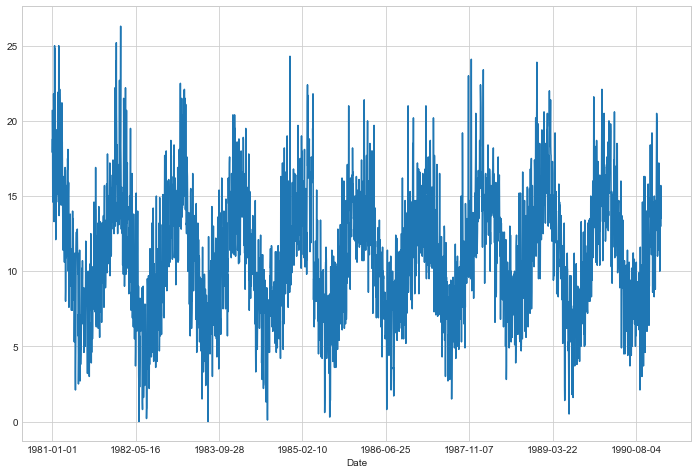

In [5]:
series.plot(figsize=figsize)
plt.show()

In [6]:
values = series.values
np.corrcoef(np.vstack([values[0:-1], values[1:]]))

array([[1.        , 0.77487022],
       [0.77487022, 1.        ]])

#### autocorrelation and lag

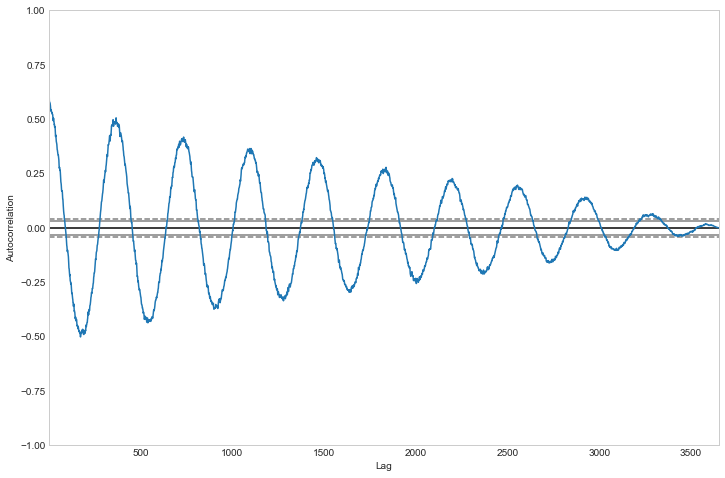

In [7]:
plt.figure(figsize=figsize)
autocorrelation_plot(series)
plt.show()

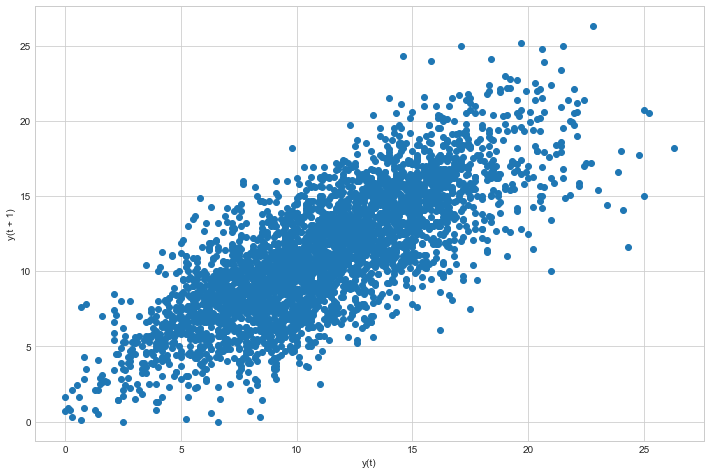

In [8]:
plt.figure(figsize=figsize)
lag_plot(series)
plt.show()

### naive model
predicts next temp to be same as current temp

In [9]:
X_test = values[-days_in_week - 1: -1]
Y_test = values[-days_in_week:]
Y_pred = X_test

In [10]:
rmse(Y_pred, Y_test), mape(Y_pred, Y_test)

(1.8500965225785224, 0.11910581302160694)

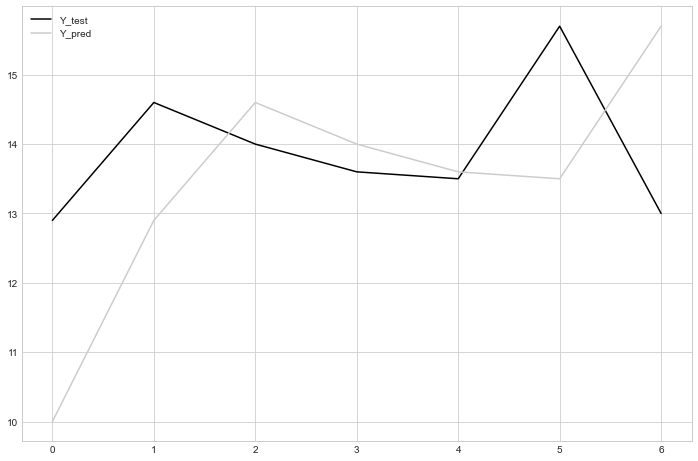

In [11]:
plt.figure(figsize=figsize)
plt.plot(Y_test, color='0', label="Y_test")
plt.plot(Y_pred, color='0.8', label="Y_pred")
plt.legend()
plt.show()

### average model
predicts next temp as average of previous temps, there previous temps may have been predicted themselves

In [12]:
X_test = values[-2*days_in_week: -days_in_week]
Y_test = values[-days_in_week:]

In [13]:
window_size = 5
window = np.ones(window_size) / window_size

In [14]:
Y_pred = list()
history = copy(X_test)
for i in range(len(Y_test)):
    y_pred = np.convolve(history[-window_size:], window, mode='valid')
    Y_pred.append(y_pred)
    history = np.append(history, Y_test[i])

In [15]:
rmse(Y_pred, Y_test), mape(Y_pred, Y_test)

(1.2323496720840692, 0.07104297580164137)

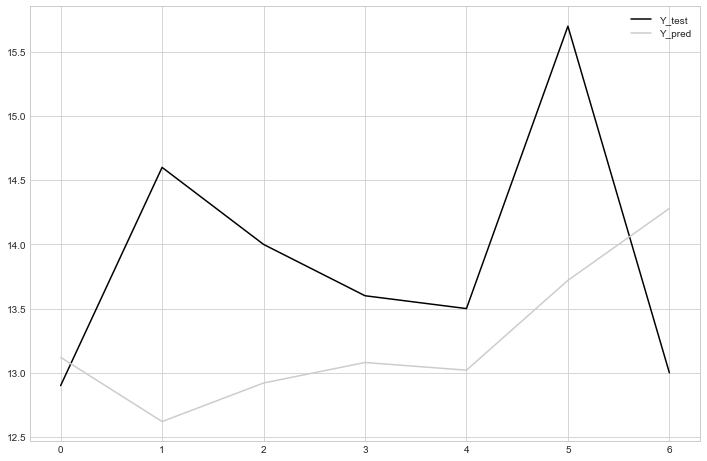

In [16]:
plt.figure(figsize=figsize)
plt.plot(Y_test, color='0', label="Y_test")
plt.plot(Y_pred, color='0.8', label="Y_pred")
plt.legend()
plt.show()

### exponential smoothing model
simple, linear, seasonal or Winters<br>
recent values play lesser role than in naive model, more role than in average model

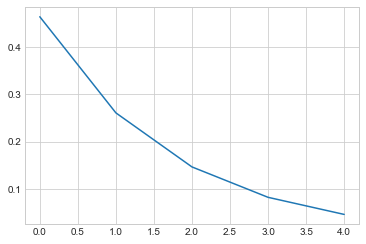

In [17]:
window_size = 5
tau = -(window_size - 1) / np.log(0.1)
window = signal.exponential(window_size, 0, tau, False)
window = window / np.sum(window)
plt.plot(window)
plt.show()

In [18]:
Y_pred = list()
history = copy(X_test)
for i in range(len(Y_test)):
    y_pred = np.convolve(history[-window_size:], window, mode='valid')
    Y_pred.append(y_pred)
    history = np.append(history, Y_test[i])

In [19]:
rmse(Y_pred, Y_test), mape(Y_pred, Y_test)

(1.3591591741943854, 0.08156684807926345)

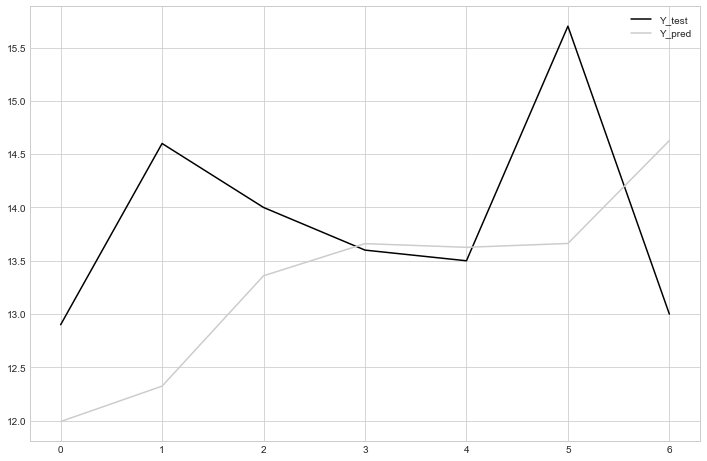

In [20]:
plt.figure(figsize=figsize)
plt.plot(Y_test, color='0', label="Y_test")
plt.plot(Y_pred, color='0.8', label="Y_pred")
plt.legend()
plt.show()

### AR model

In [21]:
X_train = values[:-days_in_week]
X_test = values[-days_in_week:]

In [22]:
lags = 30
period = 365
model = AutoReg(X_train, lags=lags, trend='c', seasonal=True, period=period)
ar_results = model.fit()

In [23]:
coefficients = ar_results.params
print(f"coefficients\n{coefficients}")

coefficients
[ 5.60563608e+00 -3.88043000e-02 -6.89699870e-01 -5.89068994e-01
 -9.15930396e-01 -1.00994898e+00  2.89038336e-01 -2.75713733e-01
 -2.94864664e-01  3.11214509e-01  2.28229457e-01  2.72137482e-01
 -3.81722195e-01  9.39061505e-01  2.96382796e-01 -1.10533827e-01
 -7.55920196e-01 -6.26816468e-01 -7.87340142e-01  8.56948677e-01
 -8.95299505e-01 -3.91280439e-01 -5.60021245e-01 -2.49129617e-01
 -1.74112062e-01 -2.81163890e-01 -4.27202628e-01 -3.19089892e-01
  7.96300340e-01  9.85095735e-01 -9.01936854e-01  2.19852628e-01
 -1.28168218e+00 -6.59728025e-02  5.03051402e-01 -1.33300204e+00
  9.40496779e-02  2.83862104e-01  1.67880321e+00  2.63751000e-01
 -1.00094510e+00 -2.48242651e-01 -3.11547265e-01  2.18730607e-01
  1.64992911e+00  1.75066905e+00  6.79218047e-01  5.33676599e-01
 -9.73955161e-01 -4.86418005e-01  5.36685597e-01  1.97522090e-01
 -2.30147108e-02 -8.81651149e-01 -1.19456972e+00 -8.93038799e-02
 -6.44943472e-01  3.02784968e-01  7.76586573e-01  7.70387361e-01
  1.74197649

#### prediction using previously predicted values
ar_results.predict(..., dynamic=True)

In [24]:
X_pred = ar_results.predict(start=len(X_train), end=len(values)-1)

In [25]:
rmse(X_test, X_pred), mape(X_test, X_pred)

(1.1910097218572349, 0.053944859499946)

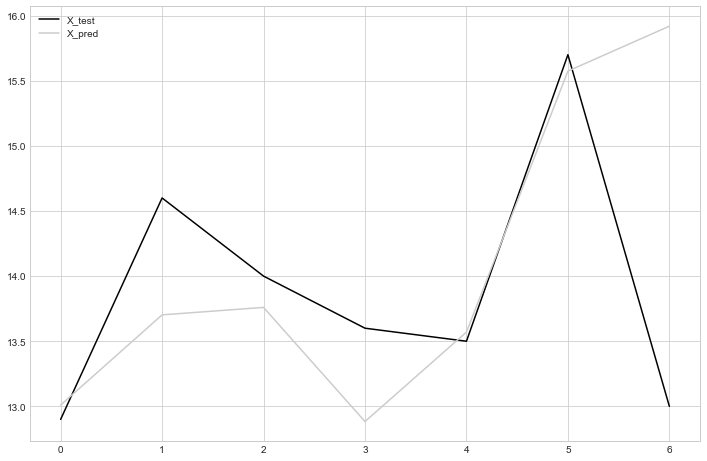

In [26]:
plt.figure(figsize=figsize)
plt.plot(X_test, color='0', label="X_test")
plt.plot(X_pred, color='0.8', label="X_pred")
plt.legend()
plt.show()

#### prediction using previous test values

In [27]:
y_intercept = coefficients[0]
history = copy(X_train[-lags: ])
X_pred = list()
for i in range(len(X_test)):
    lag_values = history[-lags: ]
    x_pred = y_intercept + np.dot(coefficients[-lags:], np.flipud(lag_values)[0:lags])
    X_pred.append(x_pred)
    history = np.append(history, X_test[i])

In [28]:
rmse(X_test, X_pred), mape(X_test, X_pred)

(1.1982051343408224, 0.06979794715663659)

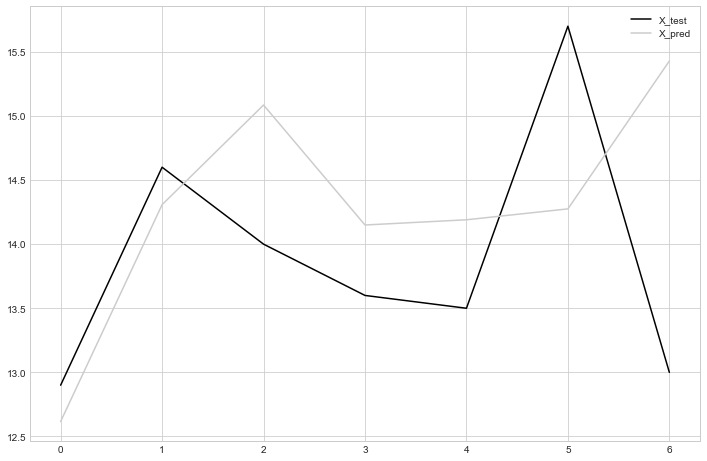

In [29]:
plt.figure(figsize=figsize)
plt.plot(X_test, color='0', label="X_test")
plt.plot(X_pred, color='0.8', label="X_pred")
plt.legend()
plt.show()

### ARIMA model

In [30]:
X_train = values[:-days_in_week]
X_test = values[-days_in_week:]

In [31]:
order = (5, 1, 0)
model = ARIMA(X_train, order=order)
arima_results = model.fit()

In [32]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3643
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8481.863
Date:                Mon, 14 Mar 2022   AIC                          16975.726
Time:                        10:26:35   BIC                          17012.928
Sample:                             0   HQIC                         16988.976
                               - 3643                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3355      0.015    -22.434      0.000      -0.365      -0.306
ar.L2         -0.3909      0.016    -24.043      0.000      -0.423      -0.359
ar.L3         -0.2941      0.017    -16.999      0.000      -0.328      -0.260
ar.L4         -0.2077      0.017    -12.466      0.000      -0.240      -0.175
ar.L5         -0.1361      0.016     -8.493      0.000      -0.168      -0.105
sigma2         6.1707      0.139     44.550      0.000       5.899       6.442
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 7.16
Prob(Q):                              0.31   Prob(JB):                         0.03
Heteroskedasticity (H):               0.86   Skew:                             0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
residuals = DataFrame(arima_results.resid)
residuals.describe()

,0
count,3643.000000
mean,0.000534
std,2.507812
min,-8.736493
25%,-1.642479
50%,0.057141
75%,1.565423
max,20.700000


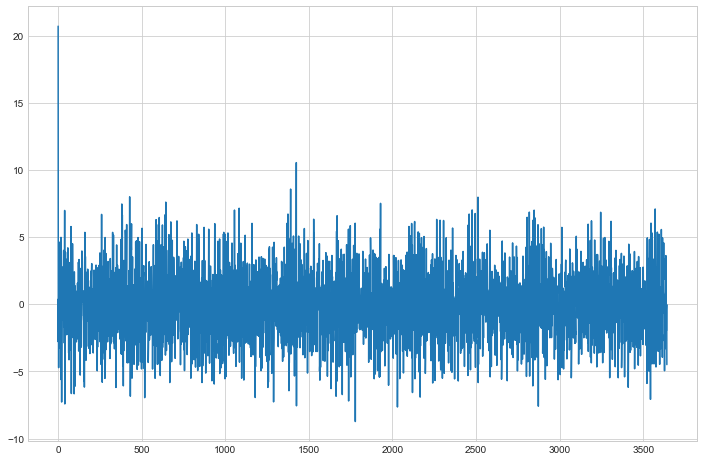

In [34]:
plt.figure(figsize=figsize)
plt.plot(residuals.values)
plt.show()

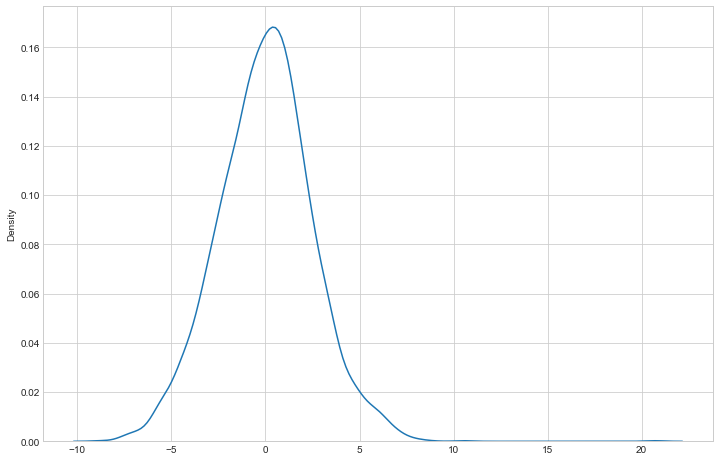

In [35]:
plt.figure(figsize=figsize)
sns.kdeplot(residuals.values[:, 0])
plt.show()

#### prediction using previous test values

In [36]:
history = copy(X_train)
X_pred = []
for i in range(len(X_test)):
    model = ARIMA(history, order=order)
    arima_results = model.fit()
    x_pred = arima_results.forecast()[0]
    X_pred.append(x_pred)
    history = np.append(history, X_test[i])

In [37]:
rmse(X_test, X_pred), mape(X_test, X_pred)

(1.4240792212506956, 0.07713964555057486)

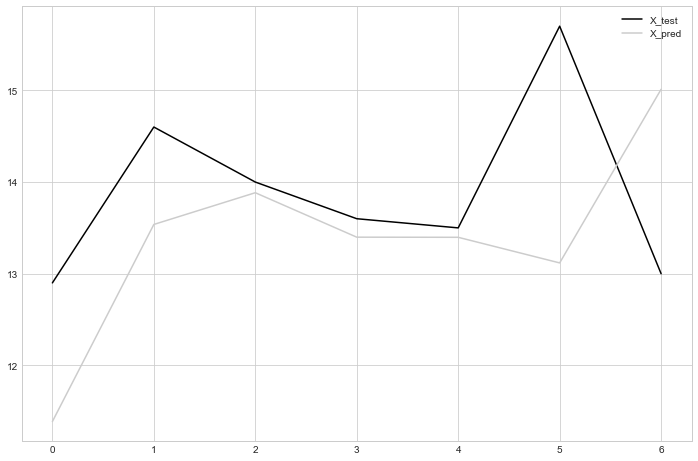

In [38]:
plt.figure(figsize=figsize)
plt.plot(X_test, color='0', label="X_test")
plt.plot(X_pred, color='0.8', label="X_pred")
plt.legend()
plt.show()